In [2]:
import tensorflow as tf

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from PIL import Image,ImageDraw
from PIL.ImageDraw import Draw

In [5]:
os.chdir('C:\\Users\\George\\Documents\\Python Scripts\\DeepTest')
os.getcwd()

'C:\\Users\\George\\Documents\\Python Scripts\\DeepTest'

In [6]:
#load dataset
os.chdir('C:\\Users\\George\\Documents\\Python Scripts\\DeepTest\\TestSet')
bbs = pd.read_csv('bb.csv',header = None)
bbs = bbs.iloc[:1000]

train_images = []

#for i in range(len(train_targets)):
for i in range(1000):
    image_name = 'test_{}.png'.format(i)
    train_img = np.asarray(Image.open(image_name))    
    train_images.append(train_img)
    
train_targets = np.array(bbs,dtype = "float32")/164.0
train_images = np.array(train_images,dtype = "float32")/255.0

In [7]:
#load validation dataset
os.chdir('C:\\Users\\George\\Documents\\Python Scripts\\DeepTest\\ValidationSet')
bbs = pd.read_csv('bb.csv',header = None)
bbs = bbs.iloc[:200]

val_images = []

#for i in range(len(train_targets)):
for i in range(200):
    image_name = 'test_{}.png'.format(i)
    val_img = np.asarray(Image.open(image_name))    
    val_images.append(val_img)
    
val_targets = np.array(bbs,dtype = "float32")/164.0
val_images = np.array(val_images,dtype = "float32")/255.0

In [10]:
#start model
height,width = 164,164
input_shape = (height,width,1) #grayscale
input_layer = tf.keras.layers.Input(input_shape)

#create the base layers - maxpooling parameter - perhaps not necessary yet?
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(input_layer)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)

In [11]:
#create output layer
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

In [12]:
model = tf.keras.Model(input_layer,locator_branch)

In [13]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 164, 164, 1)]     0         
_________________________________________________________________
bl_2 (Conv2D)                (None, 164, 164, 16)      160       
_________________________________________________________________
bl_3 (MaxPooling2D)          (None, 82, 82, 16)        0         
_________________________________________________________________
bl_4 (Conv2D)                (None, 82, 82, 32)        4640      
_________________________________________________________________
bl_5 (MaxPooling2D)          (None, 41, 41, 32)        0         
_________________________________________________________________
bl_6 (Conv2D)                (None, 41, 41, 64)        18496     
_________________________________________________________________
bl_7 (MaxPooling2D)          (None, 20, 20, 64)       

In [14]:
def calc_iou(y_true,y_pred):
    
    """
    Input :
    Keras provides the input as numpy array with shape (batch_size, num_cols)
    
    Args :
    y_true -- box, np arr with format [x,y,w,h]
    y_pred -- box, np arr with format [x,y,w,h]
    x and y are the coordinates of the top left corner
    
    Output: IoU of type float32 Max 1, Min 0
    """
    
    results = []
    
    for i in range(0,y_true.shape[0]):
        
        # set float32
        y_true = y_true.astype(np.float32)
        y_pred = y_pred.astype(np.float32)
        
        # boxTrue
        x_boxTrue_tleft = y_true[0,0]  # numpy index selection
        y_boxTrue_tleft = y_true[0,1]
        boxTrue_width = y_true[0,2]
        boxTrue_height = y_true[0,3]
        area_boxTrue = (boxTrue_width * boxTrue_height)

        # boxPred
        x_boxPred_tleft = y_pred[0,0]
        y_boxPred_tleft = y_pred[0,1]
        boxPred_width = y_pred[0,2]
        boxPred_height = y_pred[0,3]
        area_boxPred = (boxPred_width * boxPred_height)
        
        
        
        # calculate the bottom right coordinates for boxTrue and boxPred
        
        # boxTrue
        x_boxTrue_br = x_boxTrue_tleft + boxTrue_width
        y_boxTrue_br = y_boxTrue_tleft + boxTrue_height # Version 2 revision
        
        # boxPred
        x_boxPred_br = x_boxPred_tleft + boxPred_width
        y_boxPred_br = y_boxPred_tleft + boxPred_height # Version 2 revision
        
        
        
        
        # calculate the top left and bottom right coordinates for the intersection box, boxInt

        # boxInt - top left coords
        x_boxInt_tleft = np.max([x_boxTrue_tleft,x_boxPred_tleft])
        y_boxInt_tleft = np.max([y_boxTrue_tleft,y_boxPred_tleft]) # Version 2 revision
        
        # boxInt - bottom right coords
        x_boxInt_br = np.min([x_boxTrue_br,x_boxPred_br])
        y_boxInt_br = np.min([y_boxTrue_br,y_boxPred_br]) 
        
        # Calculate the area of boxInt, i.e. the area of the intersection 
        # between boxTrue and boxPred.
        # The np.max() function forces the intersection area to 0 if the boxes don't overlap.
        
        # Version 2 revision
        area_of_intersection = \
        np.max([0,(x_boxInt_br - x_boxInt_tleft)]) * np.max([0,(y_boxInt_br - y_boxInt_tleft)])

        iou = area_of_intersection / ((area_boxTrue + area_boxPred) - area_of_intersection)


        # This must match the type used in py_func
        iou = iou.astype(np.float32)
        
        # append the result to a list at the end of each loop
        results.append(iou)
    
    # return the mean IoU score for the batch
    return np.mean(results)

In [76]:
def iou_calc(bb,bb_pred):
    
    """
    New loss function over mse using areas
    
    bb is a batch of entries
    """
    ious = []
    for i in range(bb.shape[0]):
    
        #format and [x,y,w,h] data
        bb,bb_pred = bb.astype(np.float32),bb_pred.astype(np.float32)
        bb_x,bb_y,bb_w,bb_h = bb[i,0],bb[i,1],bb[i,2],bb[i,3]
        bb_pred_x,bb_pred_y,bb_pred_w,bb_pred_h = bb_pred[i,0],bb_pred[i,1],bb_pred[i,2],bb_pred[i,3]

        #areas of two bounding box
        area_bb,area_bb_true = bb_w*bb_h,bb_pred_w*bb_pred_h

        #find other coords
        bb_x2,bb_y2 = bb_x+bb_w,bb_y+bb_h
        bb_pred_x2,bb_pred_y2 = bb_pred_x+bb_pred_w,bb_pred_y+bb_pred_h

        #find bottom intersection points (max x and max y for 1 - mins for 2)
        x_,y_ = np.max([bb_x,bb_pred_x]),np.max([bb_y,bb_pred_y])
        x2_,y2_ = np.min([bb_x2,bb_pred_x2]),np.max([bb_y2,bb_pred_y2])

        #area of intersect
        area_ = np.max([0,(x2_ - x_)])*np.max([0,(y2_ - y_)])
        iou = area_ / ((area_bb_true + area_bb) - area_)
        
        ious.append(tf.cast(iou, tf.float32))
        
    return keras.backend.mean(keras.backend.square(ious))

In [77]:
temp = iou_calc(val_targets[:10],train_targets[:10])
print(temp)

tf.Tensor(0.5033134, shape=(), dtype=float32)


In [78]:
model.compile(loss = iou_calc, optimizer = 'Adam', metrics = ['accuracy']) 

In [79]:
val_targets

array([[0.4207317 , 0.4817073 , 0.04268293, 0.14634146],
       [0.23170732, 0.08536585, 0.09146342, 0.13414635],
       [0.5       , 0.6890244 , 0.04878049, 0.23170732],
       [0.22560975, 0.06097561, 0.06097561, 0.15243903],
       [0.03658536, 0.35365853, 0.23780487, 0.04268293],
       [0.47560975, 0.34146342, 0.10365853, 0.01219512],
       [0.46341464, 0.15853658, 0.08536585, 0.18292683],
       [0.15853658, 0.20731707, 0.21341464, 0.03048781],
       [0.6585366 , 0.34146342, 0.1402439 , 0.09146342],
       [0.33536586, 0.2682927 , 0.11585366, 0.11585366],
       [0.70731705, 0.5304878 , 0.20731707, 0.08536585],
       [0.5304878 , 0.63414633, 0.05487805, 0.08536585],
       [0.09146342, 0.6585366 , 0.1097561 , 0.09146342],
       [0.5365854 , 0.39634147, 0.05487805, 0.21341464],
       [0.04878049, 0.32317072, 0.1097561 , 0.09146342],
       [0.05487805, 0.4207317 , 0.05487805, 0.16463415],
       [0.50609756, 0.08536585, 0.1402439 , 0.18902439],
       [0.7195122 , 0.6097561 ,

In [80]:
history = model.fit(train_images,train_targets,
                   validation_data = (val_images, val_targets),
                   batch_size = 20,
                   epochs = 30,
                   shuffle = True,
                   verbose = 1)

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


AttributeError: in user code:

    C:\Users\George\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\George\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\George\anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\George\anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\George\anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\George\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\George\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:748 train_step
        loss = self.compiled_loss(
    C:\Users\George\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\George\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    C:\Users\George\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\George\AppData\Local\Temp/ipykernel_13692/2358712618.py:12 iou_calc  **
        bb,bb_pred = bb.astype(np.float32),bb_pred.astype(np.float32)

    AttributeError: 'Tensor' object has no attribute 'astype'


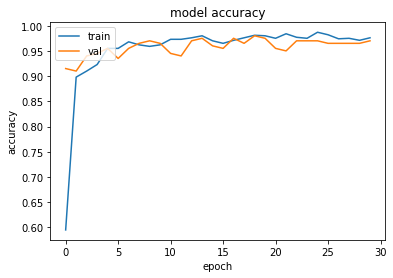

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

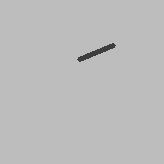

In [35]:
#read in image for prediction
os.chdir('C:\\Users\\George\\Documents\\Python Scripts\\DeepTest\\ValidationSet')
img_num = np.random.randint(0,200)
filename = 'test_{}.png'.format(img_num)
test_img = Image.open(filename)
display(test_img)

In [36]:
#convert image to array and predict with model
test_img_arr = np.array([np.asarray(test_img,dtype = "float32")/255.0])
bb_raw = model.predict(test_img_arr)
bb = bb_raw[0]*164
print(bb)

[82.09694  44.36661  34.002525 13.067192]


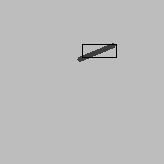

In [37]:
#display prediction
results = Draw(test_img)
results.rectangle([(bb[0],bb[1]),(bb[0]+bb[2],bb[1]+bb[3])])
display(test_img)